In [ ]:
"""
Done by:
Shankhin Brahmavar (260921778)
AND

"""

In [ ]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 KB 10.7 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
import math
import pandas as pd
import random
import matplotlib.pyplot as plt

In [ ]:
# without pytorch
cart_pole = gym.make('CartPole-v1')
seed = np.random.randn()
n_states = 400
n_actions = 2

In [ ]:
# discretizing the state space

discrete_pos = np.linspace(-2.4, 2.4, 11)[1:-1]
discrete_cart_velocity = np.linspace(-3.0, 3.0, 11)[1:-1]
discrete_pole_angle = np.linspace(-0.5, 0.5, 11)[1:-1]
discrete_angular_velocity = np.linspace(-2.0, 2.0, 11)[1:-1]

state_bins = [discrete_pos, discrete_cart_velocity, discrete_pole_angle, discrete_angular_velocity]

def discrete_state(cs):
  return sum(np.digitize(feature, bin) * len(bin) for i, (feature, bin) in enumerate(zip(cs, state_bins)))

In [ ]:
def build_q_table(state_bins, num_actions=2):
  num_states = (len(state_bins[0]) + 1) ** len(state_bins)
  return np.zeros(shape=(num_states, num_actions))

# print(build_q_table(state_bins).shape)

In [ ]:
def build_pi_table(state_bins, num_actions=2):
  num_states = (len(state_bins[0]) + 1) ** len(state_bins)
  return np.zeros(shape=(num_states, num_actions))

In [ ]:
def epsilon_greedy(q_values, state, epsilon, environment, epsilon_decay=0.3):
  if np.random.random() < epsilon:
    # choose a random action
    return environment.action_space.sample()
  else:
    # choose the optimal action based on the learned q_values
    # print(state)
    return np.argmax(q_values[state,:])

In [ ]:
def update_q(q_values, state, action, reward, next_state, alpha, epsilon, gamma, environment, weights):
  # print(q_values[state][action])
  next_action = epsilon_greedy(q_values, state, epsilon, environment)
  td_err = (reward + (gamma * np.argmax(np.multiply(q_values[next_state, next_action], weights))) - q_values[state, action])
  
  q_values[state, action] = q_values[state, action] + alpha * td_err
   # update weights-0
  # weights += np.dot(weights, (reward + gamma * np.argmax(q_values[next_state, next_action]) - q_values[state, action]) * q_values[state, action])
  # weights += np.dot(weights, 
  dw = alpha * td_err * q_values[state, action]
  weights = weights + dw
  # weights += alpha * err * state_vector

  # return next_action, td_err
  return td_err

In [ ]:
def average_error_at_timestep(err, episode_errors):
  """
  Helper function for calculating average error at each timestep
  """
  if len(episode_errors) > 1:
    episode_errors.append((episode_errors[-1] + abs(err)) / len(episode_errors))
  else:
    episode_errors.append(abs(err))

  return episode_errors

def std_error_at_timestep(err, episode_errors, std_errs):
  """
  Helper function for calculating standard error at each timestep
  """
  if len(std_errs) == 0:
    std_errs.append(np.sqrt((episode_errors[-1] - err) ** 2))
  else:
    s_err = np.sqrt(((episode_errors[-1] - err) ** 2) / len(std_errs)) * 1 / np.sqrt(len(std_errs))
    std_errs.append(s_err)

  return std_errs

In [ ]:
def q_learning(epsilon, environment, episodes, gamma, alpha, runs = 10):
  # initialize all Q(s,a) arbtirarily except that Q(terminal, .) = 0
  q_values = build_q_table(state_bins)

  # initialize weights
  weights = np.random.uniform(-0.001, 0.001, 4)
  mean_run_errors = [] * 10
  run_std_errors = [] * 10
  
  cumulative_reward = []

  for run in range(0, runs): 
    mean_episode_errors = [0] * episodes
    std_errors = [0] * episodes
    seed = np.random.randint(0,5)
    
    for episode in range(0, episodes):
      # initialize s
      state_vec, _ = environment.reset(seed=seed)

      episode_errors = []
      episode_std_errs = []
      cumulative_episode_reward = []
      
      state = discrete_state(state_vec)
      terminated = False

      i = 0
      while not terminated:
        # choose an action from the current state using the policy derived from Q
        action = epsilon_greedy(q_values, state, epsilon, environment)

        # take selected action then observe the reward, R and new state S'
        next_state_vec, reward, terminated, _, _ = environment.step(action)

        # next_state = discretize_state(next_state, weights)
        next_state = discrete_state(next_state_vec)

        # update Q(s,a) <- Q(s,a) + learning_rate * (R + gamma * max_a(Q(s',a)) - Q(s,a))
        err = update_q(q_values, state, action, reward, next_state, alpha, epsilon, gamma, environment, weights)

        average_error_at_timestep(err, episode_errors)
        std_error_at_timestep(err, episode_errors, episode_std_errs)

        if len(cumulative_episode_reward) == 0:
          cumulative_episode_reward.append(reward)
        else:
          cumulative_episode_reward.append(cumulative_episode_reward[-1] + reward)

        # update the state S <- S'
        state_vec = next_state_vec
        state = next_state

      mean_episode_errors.append(episode_errors[-1])
      cumulative_reward.append(cumulative_episode_reward[-1])
    mean_run_errors.append(sum(mean_episode_errors) / len(mean_episode_errors))
    run_std_errors.append(sum(std_errors) / len(std_errors))

  return q_values, mean_run_errors, run_std_errors

In [ ]:
mpi = build_pi_table(state_bins)

def softmax_policy(pi, d_state, theta_vector):
  # goal is to compare the probabilities of the action given the current state
  # step 1: get probability of the actions
  probs = np.exp(np.multiply(pi[d_state,:], theta_vector))

  # step 2: return the action with the greatest probability
  return np.argmax(pi[d_state,:])


In [ ]:
def update_theta_vec(learning_rate, d_state, state, action, pi, q_vals):
  error = (pi[d_state, action] - np.average(pi[d_state,]))
  d_vec = learning_rate * error * q_vals[d_state, action]
  theta_vector = theta_vector + d_vec
  return error

In [ ]:
def actor_critic(alpha_theta, alpha_w, environment, runs=10, episodes=1000):
  theta_vector = np.random.uniform(-.001, .001, 2)
  critic_weights = np.random.uniform(-0.001, .001, 4)
  terminated = False
  pi = build_pi_table(state_bins)     # actor
  q_vals = build_q_table(state_bins)  # critic

  cumulative_reward = []

  mean_run_errors = [] * 10
  run_std_errors = [] * 10  

  for run in range(0, runs):
    mean_episode_errors = [0] * episodes
    std_errors = [0] * episodes
    seed = np.random.randint(0,5)
    
    for episode in episodes:
      state_vec, _= environment.reset(seed=seed)
      d_state = discrete_state(state_vec)

      episode_errors = []
      episode_std_errors = []

      action = softmax_policy(pi, d_state, theta_vector)

      while not terminated:
        # take selected action then observe the reward, R and new state S'
        next_state_vec, reward, terminated, _, _ = environment.step(action)
        cumulative_reward.append(reward)
        d_next_state = discrete_state(next_state_vec)
        next_action = softmax_policy(pi, d_next_state, theta_vector)
        
        # update Q(s,a) <- Q(s,a) + learning_rate * (R + gamma * max_a(Q(s',a)) - Q(s,a))
        update_q(q_vals, d_state, action, reward, d_next_state, alpha, epsilon, gamma, environment, critic_weights)
        err = update_theta_vec(alpha, d_state, state_vec, action, pi, q_vals)

        average_error_at_timestep(err, episode_errors)
        std_error_at_timestep(err, episode_errors, episode_std_errors)

        action = next_action
        d_state = d_next_state

      mean_run_errors.append(sum(mean_episode_errors) / len(mean_episode_errors))
      run_std_errors.append(sum(std_errors) / len(std_errors))

  return mean_run_errors, run_std_errors

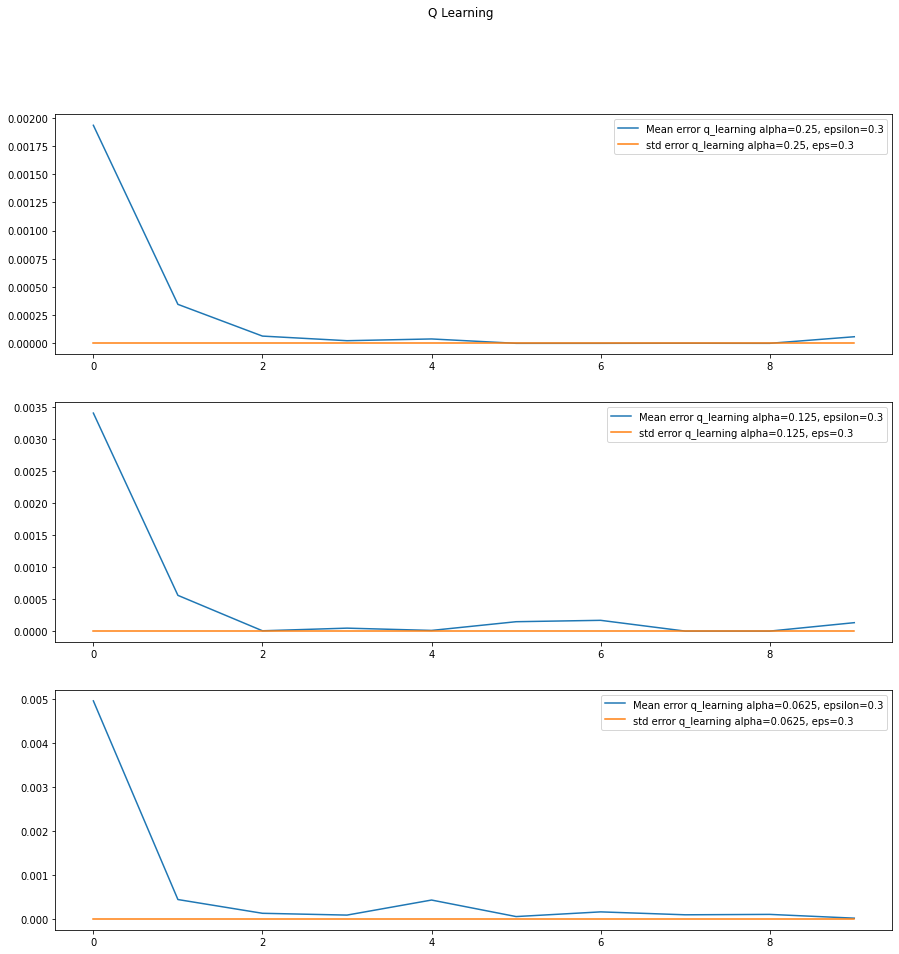

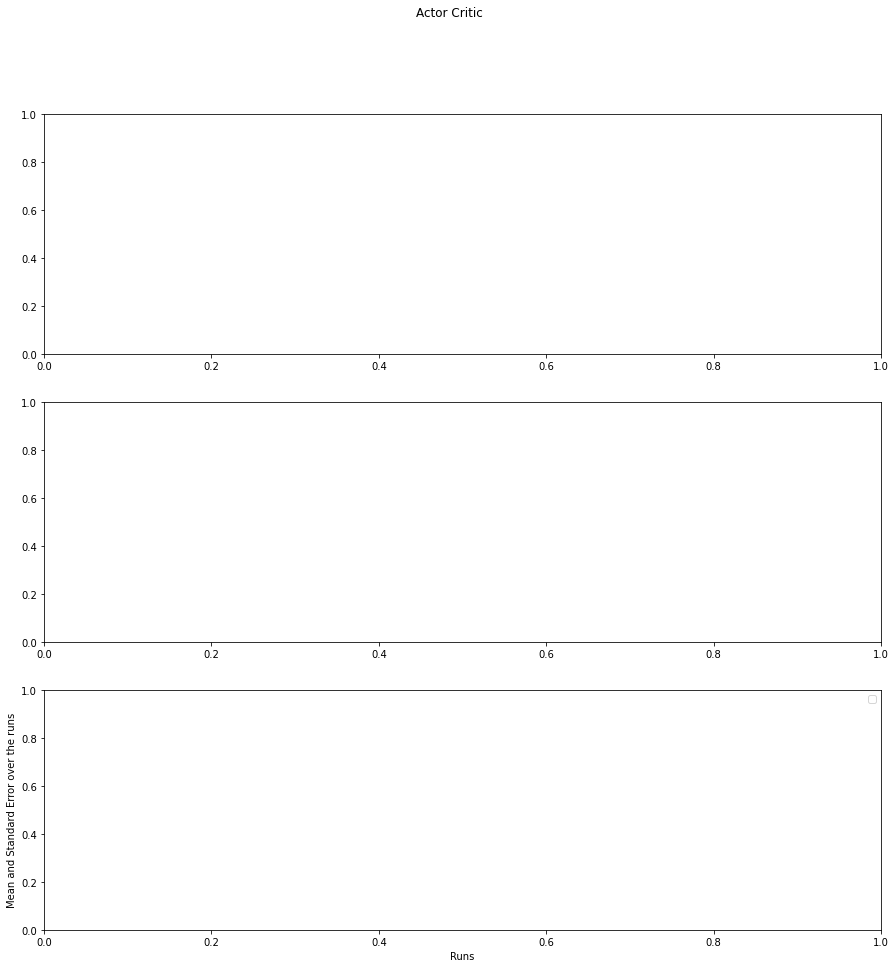

In [ ]:
learning_rates = [0.25, 0.125, 0.0625]
epsilons = [0.3]
seed = np.random.randint(0,5)
# [, 0.5, 0.7]
episodes = 1000
runs = 10
gamma = 0.7
alpha = 0.4

epsilon = 0.1
alpha = 0.25

fig1, axs1 = plt.subplots(3, figsize=(15,15))
fig1.suptitle("Q Learning")

fig2, axs2 = plt.subplots(3, figsize=(15,15))
fig2.suptitle("Actor Critic")

for i, e in enumerate(epsilons):
  plt.ylabel("Mean and Standard Error over the runs")
  plt.xlabel("Runs")
  q_learning_mean_errs = list()
  q_learning_std_errs = list()
  actor_critic_errs = list()
  for j, alpha in enumerate(learning_rates):
    learned_q_vals, mean_error, std_error = q_learning(e, cart_pole, episodes, gamma, alpha)
    # ac_mean_error, ac_std_error = actor_critic(alpha, alpha, cart_pole)
    target_plot = 0
    if j == 1:
      target_plot += 1
    elif j == 2:
      target_plot += 2
    
    axs1[target_plot].plot(np.arange(0, 10), mean_error, label=f"Mean error q_learning alpha={alpha}, epsilon={e}")
    axs1[target_plot].plot(np.arange(0, 10), std_error, label=f"std error q_learning alpha={alpha}, eps={e}")
    axs1[target_plot].legend()
  plt.legend()
  plt.show()

In [ ]:
print(std_error)
print("-------")
print(mean_error)

[0.0010404227453945111, 9.848814236506212e-07, 6.867109965631924e-08, 7.971167088568496e-09, 6.413136052121373e-16, 2.8630468770255174e-09, 5.268904351967292e-10, 6.972698561305222e-05, 8.520150372160658e-15, 6.475216361148177e-15]
-------
[0.000569741400665641, 1.0914646256968269e-06, 8.121022699401325e-08, 1.0617404290382538e-08, 7.135142438450631e-16, 3.212454184134861e-09, 5.927517422789322e-10, 7.968798356880874e-05, 9.17726224615795e-15, 7.202102371216986e-15]


In [ ]:
learned_q_vals, mean_error, std_error = q_learning(learning_rate, 0.1, cart_pole, episodes, gamma, alpha)

In [ ]:
print(std_error)
print("-------")
print(mean_error)

[0.003265063513273498, 0.002867759281535946, 0.0025768809067222465, 0.002054514186898112, 0.0023456938263943764, 0.002462732559485425, 0.003123925249159716, 0.0020208185129356885, 0.003229071448737324, 0.0020066049310789704]
-------
[0.003667764714333055, 0.003228717780052106, 0.0029164868106499415, 0.0023412654496780955, 0.002512748864749875, 0.002733859728751056, 0.003498716817599197, 0.002275742946075707, 0.0036013990993895508, 0.002242882052568269]


In [ ]:
learned_q_vals, mean_error, std_error = q_learning(learning_rate, 0.1, cart_pole, episodes, gamma, alpha)
print(std_error)
print("-------")
print(mean_error)

[0.007483353224302263, 0.0048177596258734395, 0.00292201164532508, 0.005300206169774654, 0.0019836507862986824, 0.0021157661179199913, 0.006431025357863514, 0.004336227337935996, 0.0022449022116328614, 0.0027852711877207922]
-------
[0.009564105770601421, 0.005198227999501086, 0.0032385433672035757, 0.005792601839309726, 0.002181645051797024, 0.002419154392257692, 0.0068643339305783325, 0.004724287364754324, 0.0024986284193329127, 0.0030731793844796097]
